# Project 1

Kandidate number: 15908, 15907

**Exercise 1**

Spectral lines are one of the few ways in astronomy we can find information from stellar objects.
Cecilia Payne wrote in her phD about the application of physical discoveries done on earth in astronomical observation. Specifically on how atomic physics can be used to describe spectral lines.

In the stellar spectrogram from Novotny (1973) we can only see the balmer $\beta$ line in the stellar spectrograms. This is the line marked as $H_{\beta}$ in the spectrograms. It is also possible to see the hydrogen $\gamma$, $\delta$ and $\epsilon$ marked as $H_{\gamma}$, $H_{\delta}$ and $H + H_{\epsilon}$. This is an example of how we can explain what we see when observing by particle physics. From a level structure for hydrogen we can also see that each of the series share the same lower levels, and an alpha line from a series corresponds with a beta line of the series with one less lower level.

Since a molecule or an atom absorbes the photons and then scatters photons in different directions it is logical to think that the more atoms exist in the same energy level the more photons are scattered and the line becomes stronger.

If we want to estimate the strength ratio we can start by looking at the Boltzmann law. We choose a temperature for the environment of the sample gas, and assume the gas consists of hydrogen atoms. We will also look at neutral stage atoms.
\begin{equation}
\frac{n_{1, s}}{N_{1}} = \frac{g_{1, s}}{U_{1}} e^{- \frac{X_{1, s}}{kT}}
\end{equation}
We then want to find the ratio of state $s_1$ and $s_2$.
\begin{equation}
\frac{n_{1, s_1} N_{1}}{n_{1, s_2} N_{1}} = \frac{g_{1, s_1} U_{1}}{g_{1, s_2} U_{1}} e^{- \frac{X_{1, s_1}}{kT}} e^{\frac{X_{1, s_2}}{kT}} \Rightarrow \frac{n_{1, s_1}}{n_{1, s_2}} = \frac{g_{1, s_1}}{g_{1, s_2}} e^{- \frac{X_{1, s_1} - X_{1, s_2}}{kT}}
\end{equation}
If we look at the hydrogen atom, the statistical weight is given by
\begin{equation}
g_{1, s} = 2s^2
\end{equation}
and the excitation energy
\begin{equation}
X_{1, s} = 13.598 \left( 1 - \frac{1}{s^2} \right) [\text{eV}]
\end{equation}
setting these expressios into the ratio expression, we get
\begin{equation}
\frac{n_{1, s_1}}{n_{1, s_2}} = \frac{s_1}{s_2} e^{\frac{C (s_2^2 - s_1^2)}{s_1^2 s_2^2 k T}}
\end{equation}
We can make a simple python script for this and calculate this ratio for state 1, 2, 3 and 4.

In [16]:
from astropy.units import electronvolt
from astropy.constants import k_B
from numpy import exp
def ratio(T, s1, s2):
    C = 13.598 * electronvolt
    return s1 ** 2 / (s2 ** 2) * exp(C * (s2 ** 2 - s1 ** 2) / (s1 ** 2 * s2 ** 2 * k_B * T))

Then we can use this function to calculate the ratio between all the four series, Lymann, Balmer, Paschen and Brackett.

In [17]:
from astropy.units import K
T = 5000 * K
print("n_1 / n_2 = %.2e" %(ratio(T, 1, 2)))
print("n_1 / n_3 = %.2e" %(ratio(T, 1, 3)))
print("n_1 / n_4 = %.2e" %(ratio(T, 1, 4)))
print("n_2 / n_3 = %.2e" %(ratio(T, 2, 3)))
print("n_2 / n_4 = %.2e" %(ratio(T, 2, 4)))
print("n_3 / n_4 = %.2e" %(ratio(T, 3, 4)))

n_1 / n_2 = 4.76e+09
n_1 / n_3 = 1.69e+11
n_1 / n_4 = 4.42e+11
n_2 / n_3 = 3.56e+01
n_2 / n_4 = 9.29e+01
n_3 / n_4 = 2.61e+00


We assume a linear relation between the population dencity and the strenght of the corresponding lines. Thus the population density ratio is equal to the strength ratio.

The easiest way to understand the difference between the Boltzmann and Saha distribution for rising temperature, is to plot the two and see how the distributions evolve.
We choose to just plot the general form that evolves with temperature and choose the forms
\begin{equation}
y_B = A e^{-B / T}
\end{equation}
\begin{equation}
y_S = C T^{3 / 2} e^{- D / T}
\end{equation}

We will also choose the values $A = 50$ and $B = C = D = 2$. Already here we can see that they should evolve differently since $y_B$ only has the exponential part, while $y_S$ also has a linear term to the power of three halvs.

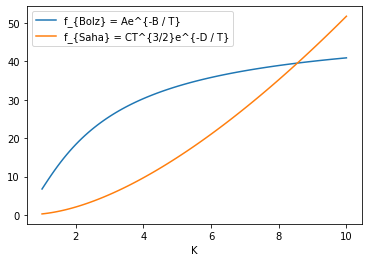

In [18]:
from numpy import linspace, exp
from matplotlib.pyplot import plot, xlabel, legend, show
T = linspace(1, 10, 100)
A = 50
B = 2
C = 2
D = 2
yB = A * exp(- B / T)
yS = C * T ** (3/2) * exp(-D / T)

plot(T, yB, T, yS)
xlabel("K")
legend([r"f_{Bolz} = Ae^{-B / T}", r"f_{Saha} = CT^{3/2}e^{-D / T}"])
show()

Here we see that the Boltzmann distribution converges towards a finite point, while the Saha distribution rises to infinity. This is as already mentioned because of the extra term in the Saha distribution.

From this we can see that the ionisation, which followes the Saha distribution rises for ever, and thus you can ionize all particles, until there are no more available. The Saha limit thus goes to infinity when all the particles in stage $N_r$ are ionized, and $N_{r+1}$ is divided by a very small number. However, the Boltzmann equation converges at some point and thus only a limited amount of particles can be excited.

**Exercise 2**

A simpflified Ca atom is modelled by including a finite number of ionization stages, each with a finite number of excitation levels. For each level, we must include the corresponding energy difference from the ground stage and its statistical weight. Thus, we can calculate number densities given by the Boltzmann and Saha laws.

We introduce the model atom with the class Atom. This class reads atomic data from a file consisting of columns with energy, statistical weight, and ionization state.

In [19]:
%matplotlib inline

import numpy as np
from astropy import units
from astropy import constants
from astropy.visualization import quantity_support
import matplotlib.pyplot as plt

In [20]:
class Atom:
    """
    Reads atomic data, calculates level populations according to Boltzmann's law,
    and ionisation fractions according to Saha's law.
    """
    
    def __init__(self, atomfile=None):
        """
        Parameters
        ----------
        atomfile : string, optional
            Name of file with atomic data. If not present, atomic data needs
            to be loaded with the .read_atom method.
        """
        self.loaded = False
        if atomfile:
            self.read_atom(atomfile)
        
    def read_atom(self, filename):
        """
        Reads atom structure from text file.
        
        Parameters
        ----------
        filename: string
            Name of file with atomic data.
        """
        tmp = np.loadtxt(filename, unpack=True)
        self.n_stages = int(tmp[2].max()) + 1
        # Get maximum number of levels in any stage
        self.max_levels = 0
        for i in range(self.n_stages):
            self.max_levels = max(self.max_levels, (tmp[2] == i).sum())
        # Populate level energies and statistical weights
        # Use a square array filled with NaNs for non-existing levels
        chi = np.empty((self.n_stages, self.max_levels))
        chi.fill(np.nan)
        self.g = np.copy(chi)
        for i in range(self.n_stages):
            nlevels = (tmp[2] == i).sum()
            chi[i, :nlevels] = tmp[0][tmp[2] == i]
            self.g[i, :nlevels] = tmp[1][tmp[2] == i]
        # Put units, convert from cm-1 to Joule
        chi = (chi / units.cm).to('aJ', equivalencies=units.spectral())
        # Save ionisation energies, saved as energy of first level in each stage
        self.chi_ion = chi[:, 0].copy()
        # Save level energies relative to ground level in each stage
        self.chi = chi - self.chi_ion[:, np.newaxis]
        self.loaded = True
        
    def compute_partition_function(self, temperature):
        if not self.loaded:
            raise ValueError("Missing atom structure, please load atom with read_atim()")
        #temp = temperature[np.newaxis, np.newaxis]
        return np.nansum(self.g[..., np.newaxis]*np.exp(-self.chi[..., np.newaxis]/(constants.k_B*temperature)),axis=1)
        
    def compute_excitation(self, temperature):
        pfunc = self.compute_partition_function(temperature)
        #reshape the arrays
        #temp = temperature[np.newaxis, np.newaxis]
        g_ratio = self.g[..., np.newaxis]/pfunc[:, np.newaxis]
        chi = self.chi[..., np.newaxis]
        return g_ratio*np.exp(-chi/(constants.k_B*temperature))
    
    def compute_ionisation(self, temperature, electron_pressure):
        partition_function = self.compute_partition_function(temperature)
        electron_density = electron_pressure/(constants.k_B*temperature)
        saha_const = ((2*np.pi*constants.m_e*constants.k_B*temperature)/constants.h**2)**(3/2)
        nstage = np.zeros_like(partition_function)/units.m**3
        nstage[0] = 1./units.m**3
        
        for r in range(self.n_stages - 1):
            nstage[r+1] = (nstage[r]/electron_density*2*saha_const*partition_function[r+1]/partition_function[r]*
                          np.exp(-self.chi_ion[r+1, np.newaxis]/(constants.k_B*temperature[np.newaxis])))
        
        return nstage/np.nansum(nstage, axis=0)
        
    def compute_populations(self, temperature, electron_pressure):
        
        return (self.compute_excitation(temperature)*self.compute_ionisation(temperature, electron_pressure)[:, np.newaxis])
    
    def plot_payne(self, temperature, electron_pressure):
        
        pops = self.compute_populations(temperature, electron_pressure)
        fig, ax = plt.subplots()
        ax.plot(np.tile(temperature, (self.n_stages, 1)).T, pops[:,0].T, 'b-')
        n_levels = self.chi.shape[1]
        if n_levels > 1:
            ax.plot(np.tile(temperature, (self.n_stages, 1)).T, pops[:,1].T, 'r--')
        if n_levels > 2:
            ax.plot(np.tile(temperature, (self.n_stages, 1)).T, pops[:,2].T, 'k:')
        ax.set_yscale('log')
        ax.set_ylim(1e-4, 1.1)
        ax.set_xlabel('Temperature [K]')
        ax.set_ylabel('Populations')

We create an instance of the class Atom for our Calcium model. By calling the method compute_partition_function, we calculate the partition function for 5000, 10000 and 20000 K.

In [21]:
my_atom = Atom("Ca_atom.txt")
tempy = np.array((5000,10000,20000))*units.K
p_func = my_atom.compute_partition_function(tempy)
for k in range(3):
    print("U_r(T = %.0f K) = (%.2f, %.2f, %.2f, %.2f, %.2f, %.2f)" %(tempy[k]/units.K, p_func[0, k], \
                                        p_func[1, k], p_func[2, k], p_func[3, k], p_func[4, k], p_func[5, k]))

U_r(T = 5000 K) = (1.17, 2.20, 1.00, 4.82, 6.91, 2.00)
U_r(T = 10000 K) = (3.46, 3.55, 1.00, 5.28, 8.08, 2.00)
U_r(T = 20000 K) = (13.63, 6.71, 1.00, 5.60, 9.65, 2.00)


We see the partition function for Calcium at the different temperatures. As the temperature gets higher, the partition function increases for all ionization stages except for $r = 2$ and $r = 5$. This comes from the exponential term $\exp\left(-\chi_{r,s}/(k_{\text{B}}T)\right)$ approaching $1$ as $T$ gets large, and these stages become saturated.

We can plot a "Payne" curve for Calcium by calling on the plot_payne method for our model atom. We use an electron pressure of 100 Pa on a temperature interval from 100 to 175000 K.

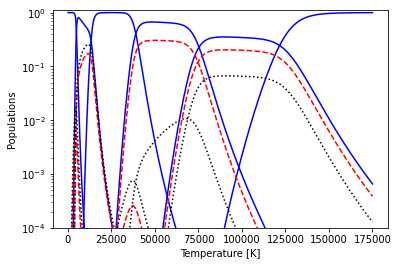

In [22]:
e_press = 100*units.Pa
tempa = np.linspace(100, 175000, 500)*units.K
my_atom.plot_payne(tempa, e_press)

Finding atomic data for oxygen from NIST, we make the file O_atom.txt to create a model oxygen atom. Using the same procedure as for calcium, we make a "Payne" curve for oxygen.

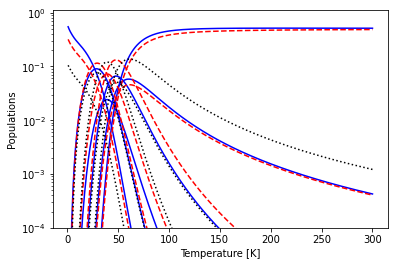

In [23]:
new_atom = Atom("O_atom.txt")
new_temp = np.linspace(1,300,500)*units.K
new_atom.plot_payne(new_temp, e_press)

As we can see from the Payne curve for oxygen, almost all of the particles come into the same ionization stage above 100 K. It seems the oxygen atom is more sensitive to lower temperatures, whereas calcium needs higher temperatures to ionize. It might also be necessary to include more ionization stages to make a more involved model for oxygen.

**Excercise 3**

As a result of the Saha Boltzmann distribution we can get a much larger amount of calcium being ionized than we get excited hydrogen. This means that we can get a stronger line for calcium ionization than we get from hydrogen excitation since the amount of radiation used to excite and ionize the different atoms are approximately the same amount.

To prove this we can compute the expected strength ratio of the two lines as functions of temperature and look at the ratio value at the temperature around the Sun's surface.

Text(0, 0.5, 'Ca II K / H$\\alpha$ strength ratio')

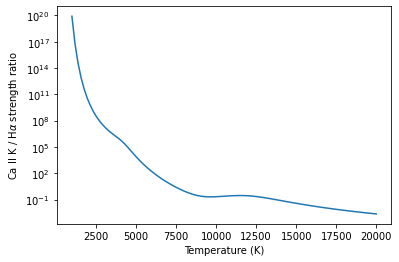

In [24]:
temp = np.linspace(1000, 20000, 100) * units.Kelvin
e_press = 10 * units.Pa

h_atom = Atom ("H_atom.txt")
ca_atom = Atom ("Ca_atom.txt")
h_pops = h_atom.compute_populations(temp, e_press)
ca_pops = ca_atom.compute_populations(temp, e_press)

ca_abund = 2 * 10 ** (-6)

ca_h_ratio = ca_pops[1, 0] / h_pops[0, 1] * ca_abund

fig, ax = plt.subplots()
ax.plot(temp, ca_h_ratio)
ax.set_yscale("log")
ax.set_xlabel(r"Temperature (K)")
ax.set_ylabel(r"Ca II K / H$\alpha$ strength ratio")

We see here that the ratio is larger than 1 around the surface temperature of the sun. This means that the line for calsium ionization is stronger than the line for the first hydrogen excitation.

We can then plot the relative population changes of the Ca$^+$ and H$\alpha$ lines as functions of temperature. From this we can look at the sensitivity of the different populations when exposed to temperature changes.

Text(0.5, 0, 'Temperature (K)')

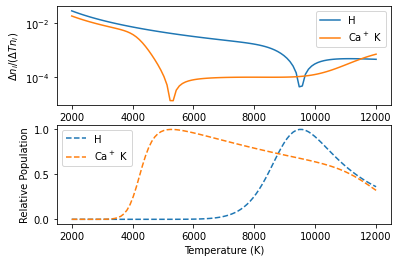

In [25]:
temp = np.linspace(2000, 12000, 100) * units.Kelvin

dT = 1 * units.Kelvin

n_ca1 = ca_atom.compute_populations(temp, e_press)[1, 0]
n_ca2 = ca_atom.compute_populations(temp - dT, e_press)[1, 0]

diff_ca = (n_ca1 - n_ca2) / (dT * n_ca1)

n_h1 = h_atom.compute_populations(temp, e_press)[0, 1]
n_h2 = h_atom.compute_populations(temp - dT, e_press)[0, 1]

diff_h = (n_h1 - n_h2) / (dT * n_h1)

fig, ax = plt.subplots(nrows = 2)
ax[0].plot(temp, np.abs(diff_h), label = r"H")
ax[0].plot(temp, np.abs(diff_ca), label = r"Ca$^+$ K")
ax[0].set_yscale("log")
ax[0].legend()
ax[0].set_ylabel(r"$\Delta n_i / (\Delta T n_i)$")

ax[1].plot(temp, n_h1 / n_h1.max(), "--", label = r"H")
ax[1].plot(temp, n_ca1 / n_ca1.max(), "--", label = r"Ca$^+$ K")
ax[1].legend()
ax[1].set_ylabel("Relative Population")
ax[1].set_xlabel("Temperature (K)")

We can see from the top plot that around the temperature of the sun, the sensitivity to temperature changes is much larger for hydrogen than it is for calcium. We can see the change in relative population in the bottom plot seen above. Here we see that the two dips in relative change happen at the exact time the popultaions reach their maximum value. Since this happens at higher temperature for hydrogen than for calcium, it is obvious that the sensitivity to change of temperature is lower for calsium than it is for hydrogen at the surface of the sun.

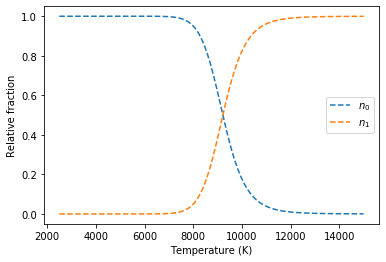

50% of hydrogen is ionized at T = [9191.91919192] K


In [69]:
tempx = np.linspace(2500,15000,100)*units.K
n = np.nansum(h_atom.compute_populations(tempx, e_press), axis=1)
n_0 = n[0]
n_1 = n[1]
plt.plot(tempx, n_0, ls = '--', label=r"$n_0$")
plt.plot(tempx, n_1, ls = '--', label=r"$n_1$")
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Relative fraction")
plt.show()
print("50% of hydrogen is ionized at T =", tempx[np.where(abs(n_0 - 0.5)<0.05)])

We see from the Plot that there are two temperature regimes where hydrogen is either neutral or ionized. For T < 8000 K, almost all of the hydrogen is neutral. For T > 10000 K almost all of the hydrogen is ionized.